In [3]:
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split, StratifiedKFold
from keras.preprocessing.text import Tokenizer

import json
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt

In [5]:
with open('json_data/2019_pass_or_fail.json', encoding='UTF8') as file:
    dataset = json.load(file)

In [6]:

# 데이터의 개수 반환
count = len(dataset)
print(count)

162000


In [7]:
# JSON 데이터를 pandas DataFrame으로 변환
df = pd.DataFrame(dataset)

# "최저 지원 유무" 열 삭제
df_modify = df.drop(columns=['최저적용유무', '최초지원결과', '지역', '전형명', '계열'])

# 빈 값이 있는 행 제거
df_modify = df_modify.replace('', pd.NA).dropna()

# 결과를 다시 JSON 형식으로 변환
modified_data = df_modify.to_dict(orient='records')

In [8]:
count = len(modified_data)
print(count)

130548


In [9]:
# 숫자로 변환하여 NumPy 배열 생성
numeric_data = np.array([
    [
        data['전과목(평균)'],
        data['국영수사(평균)'],
        data['국영수과(평균)'],
        data['국영수탐(백분위)'],
        data['국영수탐(등급)']
    ] 
    for data in modified_data
])

# 문자열 데이터를 numpy 배열로 변환 (hashing trick 적용) --> 수정 필요
string_data = np.array([
    [
        data['대학명'],
        data['학과명'],
        data['전형유형'],
    ]
    for data in modified_data
])

print(string_data[0:3])

# 각 행을 문자열로 합치기
texts = [' '.join(row) for row in string_data]

print(texts[0:3])

# Tokenizer : 문자열 -> 숫자 데이터로 임베딩 
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(texts)
encoded_texts = tokenizer.texts_to_sequences(texts)

print(encoded_texts[0:5])

# Tokenizer 설정 가져오기
tokenizer_config = tokenizer.get_config()

# 설정을 JSON 파일로 저장
with open('tokenizer_config.json', 'w') as f:
    json.dump(tokenizer_config, f)

# 결과값(합격 or 불합격)
result = np.array([data['최종지원결과'] for data in modified_data])

[['DGIST' '융복합대학(기초학부)' '종합']
 ['DGIST' '융복합대학(기초학부)' '종합']
 ['DGIST' '융복합대학(기초학부)' '종합']]
['DGIST 융복합대학(기초학부) 종합', 'DGIST 융복합대학(기초학부) 종합', 'DGIST 융복합대학(기초학부) 종합']
[[585, 586, 1], [585, 586, 1], [585, 586, 1], [585, 586, 1], [585, 586, 1]]


In [10]:
print(numeric_data[0:5])
print(string_data[0:5])
print(string_data[300:305])
print(encoded_texts[0:5])
print(result[0:5])

[['1.32' '1.31' '1.22' '252.5' '2.67']
 ['1.47' '1.51' '1.29' '281.5' '1.67']
 ['1.3' '1.3' '1.3' '225.5' '3.67']
 ['1.39' '1.44' '1.33' '224' '3.33']
 ['1.59' '1.41' '1.36' '263.5' '2.17']]
[['DGIST' '융복합대학(기초학부)' '종합']
 ['DGIST' '융복합대학(기초학부)' '종합']
 ['DGIST' '융복합대학(기초학부)' '종합']
 ['DGIST' '융복합대학(기초학부)' '종합']
 ['DGIST' '융복합대학(기초학부)' '종합']]
[['KAIST' '전학부' '종합']
 ['KAIST' '전학부' '종합']
 ['KAIST' '전학부' '종합']
 ['KAIST' '전학부' '종합']
 ['KAIST' '전학부' '종합']]
[[585, 586, 1], [585, 586, 1], [585, 586, 1], [585, 586, 1], [585, 586, 1]]
['합' '합' '합' '합' '불']


In [11]:
print(type(numeric_data))
print(type(string_data))
print(type(encoded_texts))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'list'>


In [12]:
# 숫자 데이터 float형으로 변환
numeric_data = np.array(numeric_data).astype(float)
print(numeric_data[0:2])
print(type(numeric_data))

[[  1.32   1.31   1.22 252.5    2.67]
 [  1.47   1.51   1.29 281.5    1.67]]
<class 'numpy.ndarray'>


In [13]:
# 각 1차원 배열의 길이를 추출
lengths = [len(arr) for arr in encoded_texts]

# 모든 길이가 동일한지 확인
are_lengths_equal = all(length == lengths[0] for length in lengths)
print(are_lengths_equal)

True


In [14]:
a = []
for i in lengths:
    if i!=3:
        a.append(i)
print(set(a))

set()


In [15]:
for i in range(len(lengths)):
    if lengths[i]!=3:
        print(lengths[i], string_data[i], encoded_texts[i])

In [16]:
encoded_texts = np.array(encoded_texts).astype(float)
print(encoded_texts)

[[585. 586.   1.]
 [585. 586.   1.]
 [585. 586.   1.]
 ...
 [ 19.  75.   1.]
 [ 19.  75.   4.]
 [ 19.  75.   4.]]


In [17]:
# 두 배열을 수평으로 결합
combined_data = np.concatenate((encoded_texts, numeric_data), axis=1, )
print(combined_data[0:2])

# 2차원 배열의 각 행에 대해 문자열을 정수로 변환
X = np.array(combined_data).astype(float)

# y값 문자열에 대해 원-핫 인코딩
y = np.array(result)
e = LabelEncoder()
e.fit(y)
Y = e.transform(y)

print(X[0:2])
print(X[200:202])
print(Y[0:2])

[[585.   586.     1.     1.32   1.31   1.22 252.5    2.67]
 [585.   586.     1.     1.47   1.51   1.29 281.5    1.67]]
[[585.   586.     1.     1.32   1.31   1.22 252.5    2.67]
 [585.   586.     1.     1.47   1.51   1.29 281.5    1.67]]
[[200.   201.     1.     1.59   1.41   1.36 263.5    2.17]
 [200.   201.     1.     1.3    1.28   1.37 260.5    2.  ]]
[1 1]


In [18]:
# 모델 생성
model = Sequential()
model.add(Dense(64, input_dim=8, activation='relu'))
model.add(Dense(128, activation='relu'))
# 마지막 레이어는 예측결과(sigmoid -> 0~1확률)
model.add(Dense(1, activation='sigmoid')) 

# 모델 컴파일
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 모델 실행
history = model.fit(X, Y, epochs=100, batch_size=128)



Epoch 1/100


1020/1020 [==============================] - 2s 1ms/step - loss: 0.7875 - accuracy: 0.8365
Epoch 2/100
1020/1020 [==============================] - 1s 1ms/step - loss: 0.4417 - accuracy: 0.8430
Epoch 3/100
1020/1020 [==============================] - 1s 1ms/step - loss: 0.4322 - accuracy: 0.8451
Epoch 4/100
1020/1020 [==============================] - 1s 1ms/step - loss: 0.3984 - accuracy: 0.8494
Epoch 5/100
1020/1020 [==============================] - 1s 1ms/step - loss: 0.3882 - accuracy: 0.8509
Epoch 6/100
1020/1020 [==============================] - 1s 1ms/step - loss: 0.3902 - accuracy: 0.8514
Epoch 7/100
1020/1020 [==============================] - 1s 1ms/step - loss: 0.3769 - accuracy: 0.8534
Epoch 8/100
1020/1020 [==============================] - 1s 1ms/step - loss: 0.3687 - accuracy: 0.8544
Epoch 9/100
1020/1020 [==============================] - 1s 1ms/step - loss: 0.3681 - accuracy: 0.8547
Epoch 10/100
1020/1020 [==============================] - 1s 1ms/step

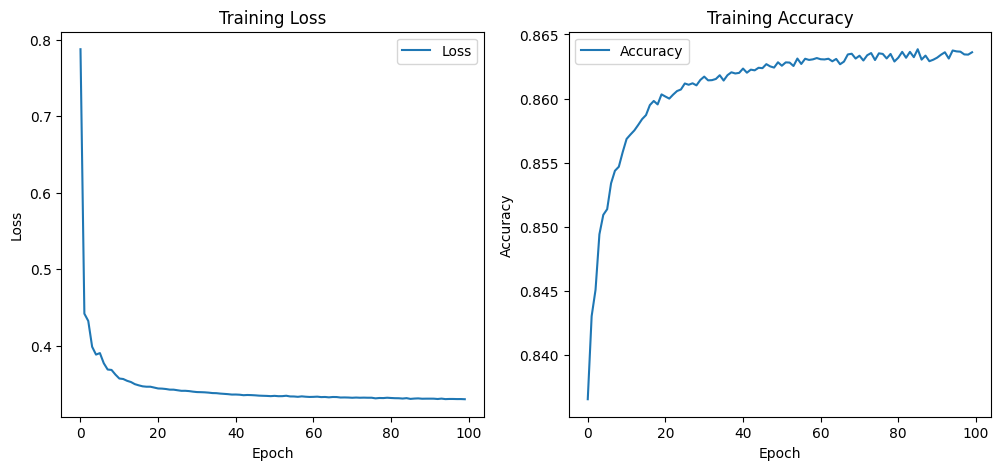

In [19]:
import matplotlib.pyplot as plt

# 훈련 손실과 정확도 그래프
plt.figure(figsize=(12, 5))

# 손실 그래프
plt.subplot(1, 2, 1)  # 1행 2열의 첫 번째 위치
plt.plot(history.history['loss'], label='Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)  # 1행 2열의 두 번째 위치
plt.plot(history.history['accuracy'], label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [13]:
# 문자열을 토큰화
input_text = ['KAIST', '전학부', '종합', 1, 1, 1, 300, 1]
input_sequence = tokenizer.texts_to_sequences([input_text[0:3]])
print(input_sequence)
input = np.concatenate((input_sequence, [input_text[3:]]), axis=1, )
print(input)
input_data = input.tolist()
print(input_data)

[[200, 201, 1]]
[[200 201   1   1   1   1 300   1]]
[[200, 201, 1, 1, 1, 1, 300, 1]]


In [16]:
# 예측
predict = model.predict(input_data)
print(predict)

1/1 [==============================] - 0s 155ms/step
[[0.7662509]]


## 모델 저장하기

In [35]:
# 모델 생성
# relu 함수 
model = Sequential()
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu')) 
# 마지막 레이어는 예측결과(sigmoid -> 0~1확률)
# Sigmoid 활성화 함수 -> 입력 값을 0과 1 사이의 값으로 변환하여 확률로 해석
model.add(Dense(1, activation='sigmoid')) 

# 모델 컴파일
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 모델 저장 폴더 만들기
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
    
modelpath = "./model/university_best_model.h5"

# 모델 업데이트 및 저장(앞에 모델보다 나아졌을때만 저장)
checkpointer = ModelCheckpoint(filepath=modelpath, moniter='loss', verbos=1, save_best_only=True)

# 학습 자동 중단 설정(학습을 계속해도 정확도에 진전이 없다면 stop)
early_stopping_callback = EarlyStopping(monitor='loss', patience=100)

# 모델 실행
model.fit(np.array(X), np.array(Y), epochs=1000, batch_size=128, validation_data=(np.array(X), np.array(Y)), verbose=0, callbacks=[early_stopping_callback, checkpointer])

C:\Users\강민지\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
